In [26]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import tensorflow as tf
from keras.layers import Input,Lambda,Dense
from keras.models import Model
import tensorflow.keras as keras 
from keras.models import Sequential

Using TensorFlow backend.


In [3]:
path_elmo = r'C:\Users\ajsal\Desktop\Model\elmo_2'
elmo = hub.Module(path_elmo)

In [4]:
def ELMO(x):
    return elmo(tf.squeeze(tf.cast(x, tf.string)),signature="default",as_dict=True)["default"]

In [5]:
def model_build():
    input_text = Input(shape = (1,),dtype = 'string')
    embedding =  Lambda(ELMO, output_shape=(1024, ))(input_text)
    dense = Dense(256,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(embedding)
    prediction = Dense(17,activation='softmax')(dense)
    model = Model(inputs=input_text, outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model    

In [6]:
def encoder(values):
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    return onehot_encoded

In [7]:
elmo_model = model_build()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [8]:
elmo_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 17)                4369      
Total params: 266,769
Trainable params: 266,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
data = pd.read_csv(r'ner_dataset.csv',encoding = "ISO-8859-1")

In [10]:
data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

In [11]:
data.tail()

,Sentence #,Word,POS,Tag
1048570,NaN,they,PRP,O
1048571,NaN,responded,VBD,O
1048572,NaN,to,TO,O
1048573,NaN,the,DT,O
1048574,NaN,attack,NN,O


In [12]:
data =data.drop(['Sentence #','POS'],axis = 1)

In [13]:
data.isna().sum()

Word    0
Tag     0
dtype: int64

In [14]:
data.shape

(1048575, 2)

In [15]:
data = data.head(100000)

In [16]:
x_train,x_test = train_test_split(data,test_size=0.3,random_state = 42)

In [17]:
y_train = np.array(x_train['Tag'])
y_test = np.array(x_test['Tag'])
x_train = np.array(x_train.drop(['Tag'],axis = 1))
x_test = np.array(x_test.drop(['Tag'],axis = 1))

In [23]:
y_train = encoder(y_train)
y_test = encoder(y_test)

In [24]:
history = elmo_model.fit(x_train,y_train,validation_split = 0.1,verbose = 1,epochs = 5,batch_size=256)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 63000 samples, validate on 7000 samples
Epoch 1/5
63000/63000 [==============================] - 19s 302us/step - loss: 0.0698 - accuracy: 0.9919 - val_loss: 0.0283 - val_accuracy: 0.9928
Epoch 2/5
63000/63000 [==============================] - 16s 259us/step - loss: 0.0273 - accuracy: 0.9927 - val_loss: 0.0281 - val_accuracy: 0.9926
Epoch 3/5
63000/63000 [==============================] - 16s 260us/step - loss: 0.0267 - accuracy: 0.9927 - val_loss: 0.0322 - val_accuracy: 0.9918
Epoch 4/5
63000/63000 [==============================] - 16s 260us/step - loss: 0.0262 - accuracy: 0.9927 - val_loss: 0.0385 - val_accuracy: 0.9874
Epoch 5/5
63000/63000 [==============================] - 16s 261us/step - loss: 0.0259 - accuracy: 0.9928 - val_loss: 0.0285 - val_accuracy: 0.9929


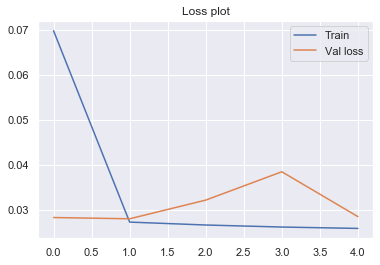

In [30]:
plt.title('Loss plot')
plt.plot(history.history['loss'],label = 'Train')
plt.plot(history.history['val_loss'],label = 'Val loss')
plt.legend()

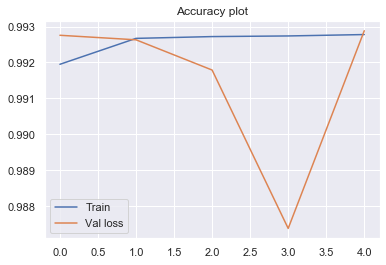

In [31]:
plt.title('Accuracy plot')
plt.plot(history.history['accuracy'],label = 'Train')
plt.plot(history.history['val_accuracy'],label = 'Val loss')
plt.legend()